# UPC-A Decode

In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from skimage import draw
import math
import copy

### Step 1. Localization

#### bbox = [xmin,ymin,xmax,ymax] is the location box of barcode (here I use the result from my pretrained barcode model)  
#### *Notice: The location box should avoid other background, it will affect the accuracy of localization of  start/end points.

In [2]:
image = cv2.imread(r'dependencies/images/070470409665.jpg',0)
image = cv2.resize(image,(image.shape[1]*2,image.shape[0]*2),
                                    interpolation=cv2.INTER_CUBIC)
bbox = [818, 780, 1002, 920]
########################################################################
# image = cv2.imread(r'dependencies/images/689076338486.jpg',0)
# image = cv2.resize(image,(image.shape[1]*2,image.shape[0]*2),
#                                     interpolation=cv2.INTER_CUBIC)
# bbox = [1282, 880, 1558, 1020]
########################################################################
# image = cv2.imread(r'dependencies/images/014149929962.bmp',0)
# bbox = [162, 186, 392, 254]

In [3]:
def bbox2points(bbox):
    [xmin, ymin, xmax, ymax] = bbox
    mid = ymin + (ymax - ymin)/2
    global r_start 
    global r_end
    global c_start
    global c_end
    r_start = int(xmin)+1
    r_end = int(xmax)-1
    c_start = int(mid)
    c_end = int(mid)
    print('X start:',xmin)
    print('X end:',xmax)
    print('Y-Mid:',mid)
    return xmin, ymin, xmax, ymax

def draw_boxes(bbox, image, color):
    left, top, right, bottom = bbox2points(bbox)
    cv2.rectangle(image, (left, top), (right, bottom), color, 1)
    return image

X start: 818
X end: 1002
Y-Mid: 850.0


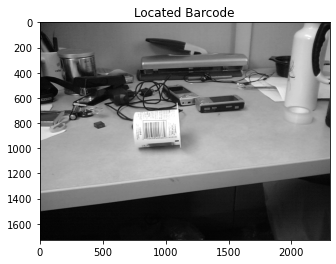

In [4]:
color = (0,0,255)
located = draw_boxes(bbox,image,color)
plt.imshow(located, cmap=plt.cm.gray)
plt.title('Located Barcode')
plt.show()

### Step 2. Intensity on scanline

#### Scanline is chosen to be the mid line of bbox.  
#### * Choose multiple scanline to get intensity for more robust and accurate results.  

Intensity on scanline: [255 255 250 236 212 191 175 173 192 223 248 254 255 255 223 175 139 135
 149 175 198 206 206 199 164 122  98 106 136 175 195 185 172 160 182 228
 255 255 251 239 202 160 136 145 166 189 206 208 206 200 206 221 240 253
 255 250 210 157 129 142 157 169 155 123 104 107 137 179 198 184 166 151
 178 231 255 255 248 229 194 162 142 147 167 192 205 197 192 193 194 194
 192 190 186 183 184 187 191 193 173 140 119 118 150 197 231 233 219 197
 166 145 133 136 171 220 249 242 228 215 197 186 159 132 117 122 148 180
 208 216 232 247 253 248 229 206 189 189 194 203 224 246 255 255 254 250
 229 202 183 182 186 192 213 237 255 255 255 255 239 208 190 195 211 231
 221 186 149 129 120 127 162 207 228 214 203 200 209 224 241 250 255 255
 255 254 254]


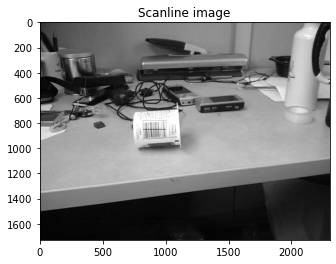

In [5]:
draw_line_image = cv2.line(located.copy(), (r_start, c_start), (r_end, c_end), (0, 0, 0), 2)
line = np.transpose(np.array(draw.line(r_start, c_start, r_end, c_end)))
intensity = located[line[:, 1], line[:, 0]]
print('Intensity on scanline:', intensity)
plt.imshow(draw_line_image, cmap=plt.cm.gray)
plt.title('Scanline image')
plt.show()

### Step 3. Localization of start/end points

In [6]:
def get_start_end_loc(intensity):
    total_luminance = 0
    avg_luminance = 0
    for n,i_n in enumerate(intensity):
        # print('current luminance:',i_n)
        if n!=0:
            avg_luminance = total_luminance/n
        # print('avg luminance before:',avg_luminance)
        if i_n < 0.85*avg_luminance:
            print('O_l found!')
            break
        total_luminance += i_n
    global o_l
    o_l = r_start+n # xmin + 1 + n
    n1 = n
    # print(n1)
    print('O_l is:',o_l) 
    total_luminance = 0
    avg_luminance = 0
    for n,i_n in enumerate(intensity[::-1]):
        # print('current luminance:',i_n)
        if n!=0:
            avg_luminance = total_luminance/n
        # print('avg luminance before:',avg_luminance)
        if i_n < 0.85*avg_luminance:
            print('O_r found!')
            break
        total_luminance += i_n
    global o_r
    o_r = r_end-n # xmax - 1 - n
    n2 = n
    # print(n2)
    print('O_r is:',o_r)
    print('new_intensity:',intensity[n1:-n2])
    intensity = intensity[n1:-n2]
    
    return intensity

O_l found!
O_l is: 824
O_r found!
O_r is: 993
new_intensity: [191 175 173 192 223 248 254 255 255 223 175 139 135 149 175 198 206 206
 199 164 122  98 106 136 175 195 185 172 160 182 228 255 255 251 239 202
 160 136 145 166 189 206 208 206 200 206 221 240 253 255 250 210 157 129
 142 157 169 155 123 104 107 137 179 198 184 166 151 178 231 255 255 248
 229 194 162 142 147 167 192 205 197 192 193 194 194 192 190 186 183 184
 187 191 193 173 140 119 118 150 197 231 233 219 197 166 145 133 136 171
 220 249 242 228 215 197 186 159 132 117 122 148 180 208 216 232 247 253
 248 229 206 189 189 194 203 224 246 255 255 254 250 229 202 183 182 186
 192 213 237 255 255 255 255 239 208 190 195 211 231 221 186 149 129 120
 127 162 207 228 214 203 200 209]


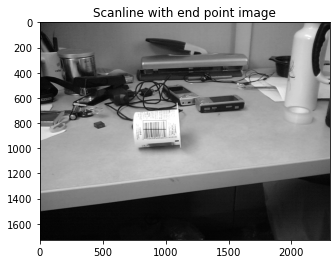

In [7]:
intensity = get_start_end_loc(intensity)
cv2.circle(draw_line_image, (o_l,c_start), 2, (255, 0, 0), 1)
cv2.circle(draw_line_image, (o_r,c_end), 2, (255, 0, 0), 1)
plt.imshow(draw_line_image, cmap=plt.cm.gray)
plt.title('Scanline with end point image')
plt.show()

### Step 4. Intensity profile's statistics

#### ub（average black intensity），uw（average white intensity），var（varience）. These values will be used to load templates.

In [8]:
def get_ub_uw_var(intensity):
    sorted_intensity = sorted(intensity)
    middle_index = len(sorted_intensity)//2
    ub = np.mean(sorted_intensity[:middle_index])
    uw = np.mean(sorted_intensity[middle_index:])
    var = np.var(sorted_intensity)
    return ub,uw,var

In [9]:
ub,uw,var = get_ub_uw_var(intensity)
print('ub,uw,var:',ub,uw,var)

ub,uw,var: 160.14117647058825 225.50588235294117 1646.1570934256056


### Step 5. Load decoding templates

#### The algorithm is based on templates matching, we need to predefine templates first. 
1. use ub as black values，uw as white bar value
2. one ub/uw stands for base width
3. add one base width in the begining and the end of templates  

#### Templates are represented as arrays. For example, template of digit 0 is array：m0 = [ub,uw,uw,uw,ub,ub,uw,ub,uw]，which means[black（base width added at begining）,white, white, white,black,black,white,black,white(base width added at the end)]  
#### the templates loading for code 39 and code 128 followed the rules. In code 128 we only considered templates of set C.

In [10]:
def get_upc_models(ub,uw,intensity):
    m0 = [ub,uw,uw,uw,ub,ub,uw,ub,uw]
    m1 = [ub,uw,uw,ub,ub,uw,uw,ub,uw]
    m2 = [ub,uw,uw,ub,uw,uw,ub,ub,uw]
    m3 = [ub,uw,ub,ub,ub,ub,uw,ub,uw]
    m4 = [ub,uw,ub,uw,uw,uw,ub,ub,uw]
    m5 = [ub,uw,ub,ub,uw,uw,uw,ub,uw]
    m6 = [ub,uw,ub,uw,ub,ub,ub,ub,uw]
    m7 = [ub,uw,ub,ub,ub,uw,ub,ub,uw]
    m8 = [ub,uw,ub,ub,uw,ub,ub,ub,uw]
    m9 = [ub,uw,uw,uw,ub,uw,ub,ub,uw]

    m0_ = [uw,ub,ub,ub,uw,uw,ub,uw,ub]
    m1_ = [uw,ub,ub,uw,uw,ub,ub,uw,ub]
    m2_ = [uw,ub,ub,uw,ub,ub,uw,uw,ub]
    m3_ = [uw,ub,uw,uw,uw,uw,ub,uw,ub]
    m4_ = [uw,ub,uw,ub,ub,ub,uw,uw,ub]
    m5_ = [uw,ub,uw,uw,ub,ub,ub,uw,ub]
    m6_ = [uw,ub,uw,ub,uw,uw,uw,uw,ub]
    m7_ = [uw,ub,uw,uw,uw,ub,uw,uw,ub]
    m8_ = [uw,ub,uw,uw,ub,uw,uw,uw,ub]
    m9_ = [uw,ub,ub,ub,uw,ub,uw,uw,ub]
    
    xm = np.arange(-1,8)
    
    dict_m0 = dict(zip(xm, m0))
    dict_m1 = dict(zip(xm, m1))
    dict_m2 = dict(zip(xm, m2))
    dict_m3 = dict(zip(xm, m3))
    dict_m4 = dict(zip(xm, m4))
    dict_m5 = dict(zip(xm, m5))
    dict_m6 = dict(zip(xm, m6))
    dict_m7 = dict(zip(xm, m7))
    dict_m8 = dict(zip(xm, m8))
    dict_m9 = dict(zip(xm, m9))

    dict_m0_ = dict(zip(xm, m0_))
    dict_m1_ = dict(zip(xm, m1_))
    dict_m2_ = dict(zip(xm, m2_))
    dict_m3_ = dict(zip(xm, m3_))
    dict_m4_ = dict(zip(xm, m4_))
    dict_m5_ = dict(zip(xm, m5_))
    dict_m6_ = dict(zip(xm, m6_))
    dict_m7_ = dict(zip(xm, m7_))
    dict_m8_ = dict(zip(xm, m8_))
    dict_m9_ = dict(zip(xm, m9_))

    model_list1 = [dict_m0,dict_m1,dict_m2,dict_m3,dict_m4,dict_m5,dict_m6,dict_m7,dict_m8,dict_m9]
    model_list2 = [dict_m0_,dict_m1_,dict_m2_,dict_m3_,dict_m4_,dict_m5_,dict_m6_,dict_m7_,dict_m8_,dict_m9_]
    
    return model_list1,model_list2

In [11]:
model_list1,model_list2 = get_upc_models(ub,uw,intensity)

### Step 6. Decoding

#### Algorithm：
1. The outer loop: d_o controls the left/right movement of the matching template, d_w controls the expansion/contraction of the matching template.
2. Inner loop j，is the loop for digits，i.e.：upc-a has 12 encoding digits, we loop from 1-12.
3. w is the base width，for example：for upc-a has 95 base widths (start 3+ end 3+ middle 5+ each digit 7 × 12 digits),so the base width w=（barcode length/95）  

#### Notes：
1. In the demo example, the w in code39，code128 is predefined，as our application scenario has prior knowledge of encoding patterns, for other applications decoding variable length code, this algorithm may not work.
2. Range and step size of the loop d_o，d_w will affect decoding performance，need to tune it for different applications。
3. Decoding limits is w > 1 pixel，images that w < 1 pixel need resized. But resizing will lose some of the information, you may not get ideal results.
4. To improve efficiency，store D(M(K),n) for reuse.

In [12]:
def decode_upc(ub,uw,var,intensity,model_list1,model_list2):
    x = np.arange(len(intensity))
    dict_I = dict(zip(x,intensity))
    o_start = 0  
    result_x = np.arange(1,13)
    result_y = [[100]*10]*12
    result_dict = dict(zip(result_x,result_y))
    d_w = 0
    d_o = 0
    w = len(intensity)/95
    print('Base Width is:',w)
    if w - (math.floor(w))<= 0.5:
        do = math.floor(w)
    else:
        do = math.floor(w)+1

    for d_o in np.arange(-do, do+1, 1):
        for d_w in np.arange(-0.025,0.025+0.01,0.01):
            try:
                detected = []
                o_start = d_o+1
                for j in range(1,13):
                    temp_res = copy.deepcopy(result_dict[j])
                    if j >= 7:
                        o = o_start+8*(w+d_w)+7*(w+d_w)*(j-1)
                        model_list = model_list2
                    else:
                        o = o_start+3*(w+d_w)+7*(w+d_w)*(j-1)
                        model_list = model_list1
                    D_result = []
                    seg_start = math.ceil(o-(w+d_w))
                    seg_end = math.floor(o+8*(w+d_w))
                    for k,dict_m in enumerate(model_list):
                        D_list = []
                        for n in range(seg_start, seg_end+1):
                            I_n = dict_I[n]
                            m_x = math.floor((n-o)/w)
                            m_y = dict_m[m_x]
                            if m_y == ub:
                                D = ((max(0,I_n-ub))**2)/(2*var**2)
                                D_list.append(D)
                            elif m_y == uw:
                                D = ((min(0,I_n-uw))**2)/(2*var**2)
                                D_list.append(D)
                            else:
                                print('ERROR!!!!!!')
                        D_result.append(sum(D_list))
                    k = D_result.index(min(D_result))
                    if min(D_result) < temp_res[k]:
                        temp_res[k] = min(D_result)
                        result_dict[j] = temp_res
                    temp_res = []
                    detected.append(D_result.index(min(D_result)))
            except:
                continue
    final_res = []
    for res in result_dict.values():
        k = res.index(min(res))
        final_res.append(k)
    print('Final Result:',final_res)
    return final_res

In [13]:
decode_upc(ub,uw,var,intensity,model_list1,model_list2)

Base Width is: 1.7894736842105263
Final Result: [0, 7, 0, 4, 7, 0, 4, 0, 9, 6, 6, 5]


[0, 7, 0, 4, 7, 0, 4, 0, 9, 6, 6, 5]